In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [824]:
#df = pd.read_csv("../data/consumer/braila_test.csv")

df = pd.read_csv("../data/consumer/braila_test.csv")

display(df)


#(x_train,y_train), _ = mnist.load_data ()
#x_train = x_train.astype('float32')/255.0
#x_train = x_train.reshape((len(x_train),np.prod(x_train.shape [1:])))

,timestamp,analog2,tot1,tot2
0,2019-10-21 13:30:00,0.819333,452506.864000,-285.31
1,2019-10-21 13:45:00,0.821333,452521.260667,-285.31
2,2019-10-21 14:00:00,0.820000,452535.552000,-285.31
3,2019-10-21 14:15:00,0.820000,452551.006000,-285.31
4,2019-10-21 14:30:00,0.814667,452564.722667,-285.31
...,...,...,...,...
15624,2020-04-01 07:30:00,0.818000,797057.012000,-293.97
15625,2020-04-01 07:45:00,0.811333,797090.365333,-293.97
15626,2020-04-01 08:00:00,0.815333,797123.492000,-293.97
15627,2020-04-01 08:15:00,0.814667,797158.222000,-293.97


In [825]:
N = 6
FVs = []
for i in range(N, len(df)):
    FV = df['analog2'][i-N:i]
    FVs.append(np.array(FV))
FVs = np.array(FVs)
print(FVs.shape)

x_train = (FVs-0.8)

(15623, 6)


In [826]:
original_dim = np.prod(x_train.shape [1:]) # dimenzija vhodnih podatkov
print(original_dim)
hidden_dim = 10 # skriti sloj z 64 node -i
latent_dim = 3 # 2D latentni prostor
inputs = keras.Input(shape =(original_dim ,))
h1 = keras.layers.Dense(hidden_dim, activation ='linear')(inputs)
h2 = keras.layers.Dense(hidden_dim, activation ='tanh')(h1)
h3 = keras.layers.Dense(hidden_dim, activation ='tanh')(h2)

h4 = keras.layers.Dense(latent_dim, activation ='tanh')(h3)

z_mean = keras.layers.Dense(latent_dim)(h3)
z_log_var = keras.layers.Dense(latent_dim)(h3)

6


In [759]:
def sampling ( args ):
    z_mean , z_log_var = args
    epsilon = K.random_normal(shape = (K.shape(z_mean)[0], latent_dim), mean =0.0 , stddev =1.0)
    return (z_mean + K.exp(0.5*z_log_var)*epsilon)

In [839]:
z = keras.layers.Lambda(sampling)([z_mean , z_log_var ])

#encoder = keras.Model(inputs, [z_mean , z_log_var , z], name ='encoder')

encoder = keras.Model(inputs, outputs = [h4, h4], name = 'encoder')

#latent_inputs = keras.Input(shape =(latent_dim,), name ='z_sampling')
latent_inputs = keras.Input(shape =latent_dim, name ='z_sampling')

x1 = keras.layers.Dense(hidden_dim , activation ='tanh')(latent_inputs)
x2 = keras.layers.Dense(hidden_dim , activation ='relu')(x1)
x3 = keras.layers.Dense(hidden_dim , activation ='relu')(x2)


outputs = keras.layers.Dense(original_dim , activation ='linear')(x3)
decoder = keras.Model(latent_inputs, outputs, name ='decoder')

outputs = decoder(encoder(inputs)[0])
vae = keras.Model(inputs, outputs, name ='vae')

#rec_loss = keras.losses.mean_squared_error(inputs, outputs)
def wasserstein_loss(y_true, y_pred):
    return K.mean(y_true * y_pred)
mse = tf.keras.losses.MeanSquaredError()

rec_loss = mse(inputs, outputs)

rec_loss *= 1000*original_dim
kl_loss = -0.0*K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var) , axis =-1)
vae_loss = K.mean(rec_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer =tf.keras.optimizers.Adam(lr = 0.001, beta_1 = 0.95))

In [840]:
batch_size = 5
vae.fit(x_train[:5000],x_train[:5000], epochs =100, batch_size = batch_size, validation_data = None, verbose = 1)

Epoch 1/100
1000/1000 [==============================] - 12s 2ms/step - loss: 1.9328
Epoch 2/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.1275
Epoch 3/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0873
Epoch 4/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0777
Epoch 5/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0822
Epoch 6/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0808
Epoch 7/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0772
Epoch 8/100
1000/1000 [==============================] - 1s 992us/step - loss: 0.0769
Epoch 9/100
1000/1000 [==============================] - 1s 865us/step - loss: 0.0727
Epoch 10/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0709
Epoch 11/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0692
Epoch 12/100
1000/1000 [==============================] - 2s 2ms/step

1000/1000 [==============================] - 2s 2ms/step - loss: 0.0585
Epoch 98/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0573
Epoch 99/100
1000/1000 [==============================] - 2s 2ms/step - loss: 0.0591
Epoch 100/100
1000/1000 [==============================] - 1s 1ms/step - loss: 0.0611


[[0.13490823 0.07731966 0.0415007 ]
 [0.14434929 0.08035024 0.04286629]
 [0.14436637 0.08661168 0.05264575]
 ...
 [0.12879804 0.04522984 0.0363702 ]
 [0.12170124 0.06862374 0.04349766]
 [0.11623635 0.08814537 0.04514172]]


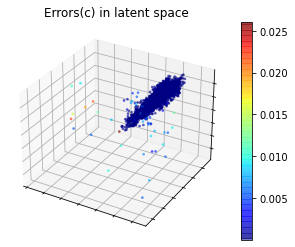

In [752]:
from mpl_toolkits import mplot3d
x_encoded = encoder.predict(x_train)[0]
print(x_encoded)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter3D(x_encoded[:,0], x_encoded[:,1], x_encoded[:,2],c = errors, cmap='jet', alpha = 0.5, s = 3)
ax.axes.xaxis.set_ticklabels([])
ax.axes.yaxis.set_ticklabels([])
ax.axes.zaxis.set_ticklabels([])
ax.set_title("Errors(c) in latent space")
fig.colorbar(p)
plt.savefig("GAN_Braila_LatentSpace")

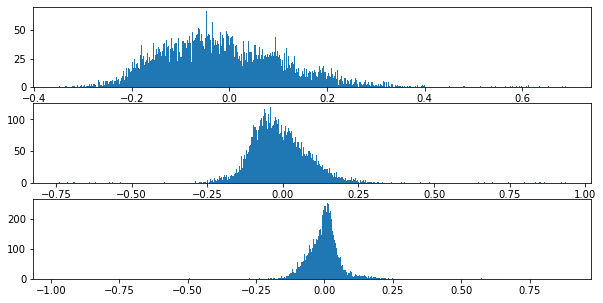

In [734]:
fig, axarr = plt.subplots(3, 1, figsize = (10, 5))
axarr[0].hist(x_encoded[:,0], bins = 500)
axarr[1].hist(x_encoded[:,1], bins = 500)
axarr[2].hist(x_encoded[:,2], bins = 500)
plt.show()

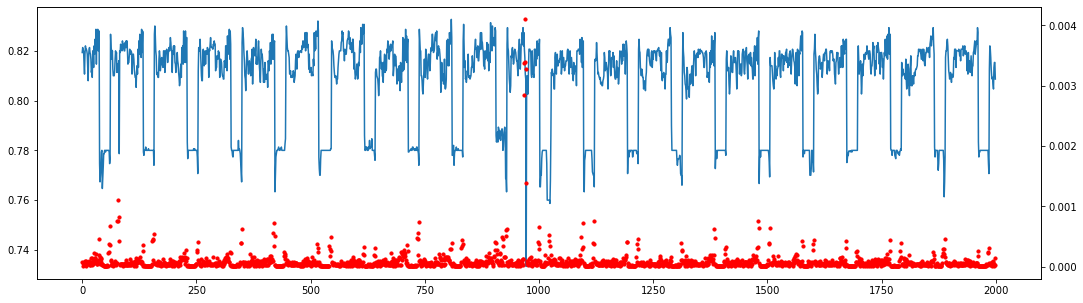

In [838]:
x_pred = vae.predict(x_train)
fr = 0
to = 2000
#plt.plot(x_pred[n], c = 'r')
#plt.plot(x_train[n], c = 'k')

def mse(vec1, vec2):
    mse = np.sum((np.add(np.array(vec1), -np.array(vec2))**2))
    return(mse)

latent = encoder.predict(x_train)[0]
errors = []
for i in range(len(x_pred)):
    errors.append(mse(x_pred[i], x_train[i]))

fig, ax1 = plt.subplots(figsize = (18, 5))
ax1.plot(df['analog2'][fr:to])

ax2 = ax1.twinx()

ax2.scatter(range(fr,to),errors[fr:to], c = 'r', s = 10)
#ax2.scatter(range(fr+19,to),np.convolve(errors[fr:to], np.ones(20)/20, mode='valid'), c = 'r', s = 10)
#ax2.set_yscale('log')
#plt.savefig("Autoencoder_mse_AD.png", dpi = 100)

In [794]:
x_pred = vae.predict(x_train[0].reshape(1, 10))
print(x_pred)

print(x_train[0])
print(x_train[:1])
print([x_train[0]])

[[0.17212178 0.18316369 0.18675467 0.19695741 0.20198415 0.20568442
  0.21103474 0.21048076 0.21366991 0.2131257 ]]
[0.18 0.18 0.18 0.19 0.2  0.21 0.22 0.21 0.21 0.21]
[[0.18 0.18 0.18 0.19 0.2  0.21 0.22 0.21 0.21 0.21]]
[array([0.18, 0.18, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.21, 0.21, 0.21])]


417
0.2187533462723588
418
0.15339291557701473
419
0.10419882674433888
420
0.229843729600944
421
0.2280641832185031
422
0.2593762074771818
423
0.12570329964018628
426
0.1154376846837899
427
0.21874054769338358
1569
0.6341270063715322
1570
0.45144905286190856
1571
0.4427651476997965
1572
0.9294635811233807
1573
0.683276010366329
1574
0.2337558164323767
1575
0.6334667619722952
1576
0.3601394741835532
2234
0.1176627061159622
2235
0.14141086305511247
4110
0.11261803340976942
4111
0.15436797725701193
4112
0.15435593906959014
4113
0.12513630815592158
4114
0.10430105930602054


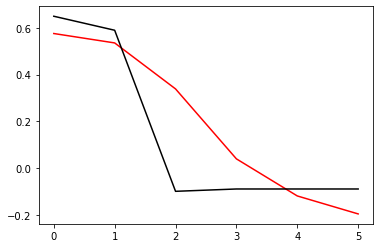

In [582]:
for i in range(5000):
    if(errors[i]>0.1):
        print(i)
        print(errors[i])
n = 420
plt.plot(x_pred[n], c = 'r')
plt.plot(x_train[n], c = 'k')